In [ ]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch import tensor
from utils.load_folktables import prepare_folktables
from src.constraints.constraint_fns import *
from fairret.statistic import *
from utils.network import SimpleNet

This notebook presents some useful plots based on the performance of the trained models.

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [ ]:
TASK = "income"
# TASK = 'employment'
STATE = "OK"

In [ ]:
(
    X_train,
    y_train,
    [w_idx_train, nw_idx_train],
    X_test,
    y_test,
    [w_idx_test, nw_idx_test],
) = prepare_folktables(
    TASK, state=STATE, random_state=42, make_unbalanced=False, onehot=False, download=True
)

sensitive_value_0 = "white"
sensitive_value_1 = "non-white"

c:\Users\andre\phd\humancompatible-train\experiments\utils\raw_data\2018\1-Year\definition.csv


c:\Users\andre\miniconda3\envs\humancompatible\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [ ]:
device = "cuda" if torch.cuda.is_available() and False else "cpu"

In [ ]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)

X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)

X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]

X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]

In [ ]:
print("w, nw, total")
print("train")
print(len(y_train_w), len(y_train_nw), len(y_train))
print(
    sum(y_train_w == 1) / len(y_train_w),
    sum(y_train_nw == 1) / len(y_train_nw),
    sum(y_train_tensor == 1) / len(y_train_tensor),
)
print("test")
print(len(y_test_w), len(y_test_nw), len(y_test))
print(
    sum(y_test_w == 1) / len(y_test_w),
    sum(y_test_nw == 1) / len(y_test_nw),
    sum(y_test_tensor == 1) / len(y_test_tensor),
)

w, nw, total
train
10680 3653 14333
tensor(0.3081) tensor(0.2078) tensor(0.2825)
test
2670 914 3584
tensor(0.3075) tensor(0.2068) tensor(0.2818)


**Load saved models**

In [ ]:
# directory to load models from

LOSS_BOUND = 0.005
DATASET = TASK + "_" + STATE
constraint = "eq_loss"
DIRECTORY_PATH = (
    "./utils/saved_models/"
    + DATASET
    + "/"
    + constraint
    + "/"
    + f"{LOSS_BOUND:.0e}"
    + "/"
)
FILE_EXT = ".pt"

In [ ]:
loaded_models = []
directory_path = DIRECTORY_PATH
file_list = os.listdir(directory_path)
model_files = [file for file in file_list if file.endswith(FILE_EXT)]
for model_file in model_files:
    model_name = model_file
    model = SimpleNet(X_test.shape[1], 1, torch.float32).to(device)
    print(model_file, end="\r")
    try:
        model.load_state_dict(
            torch.load(
                directory_path + model_name, weights_only=False, map_location=device
            )
        )
    except:
        continue
    model_file = str.join("", model_file.split("_trial")[:-1])
    loaded_models.append((model_file, model))

### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.. and aggregate per algorithm:**

In [ ]:
from utils.stats import make_model_stats_table
from utils.stats import aggregate_model_stats_table

**Train set**:

In [ ]:
res_df_train = make_model_stats_table(X_train_w, y_train_w, X_train_nw, y_train_nw, loaded_models)

train_df = aggregate_model_stats_table(res_df_train, "mean")
train_df_std = aggregate_model_stats_table(res_df_train, ["mean", "std"])
train_df_std

AUC_M                 Ind                  Sp  \
                           mean       std      mean       std      mean   
Algorithm                                                                 
ALM_0.005              0.799853  0.009689  0.055931  0.012291  0.057995   
SGD_0.005              0.843000  0.001048  0.096298  0.005392  0.130609   
SSLALM_0.005           0.802019  0.009348   0.05207  0.010478  0.051862   
StochasticGhost_0.005  0.768542  0.038853  0.048403  0.020930  0.057889   
fairret_0.005          0.849718  0.001017   0.08734  0.013240  0.119011   

                                      Ina                  Sf            \
                            std      mean       std      mean       std   
Algorithm                                                                 
ALM_0.005              0.012094  0.247164  0.009997  0.195677  0.013160   
SGD_0.005              0.007288  0.203614  0.001591  0.111664  0.009255   
SSLALM_0.005           0.014082  0.240389  0.010992  0.201729  0.014836   
StochasticGhost_0.005  0.032721  0.283262  0.048133   0.19045  0.025020   
fairret_0.005          0.017974  0.202944  0.003356   0.10602  0.009814   

                             Wd           |Loss_0 - Loss_1|           Algname  
                           mean       std              mean       std          
Algorithm                                                                      
ALM_0.005              0.002509  0.000725          0.021376  0.016707     NaN  
SGD_0.005              0.007386  0.000292          0.063324  0.001281     NaN  
SSLALM_0.005           0.002441  0.000569          0.017719  0.019514     NaN  
StochasticGhost_0.005  0.000955  0.000639          0.024878  0.014794     NaN  
fairret_0.005          0.006516  0.001489          0.072428  0.005458     NaN

**Test set**:

In [ ]:
res_df_test = make_model_stats_table(X_test_w, y_test_w, X_test_nw, y_test_nw, loaded_models)

test_df = aggregate_model_stats_table(res_df_test, "mean")
test_df_std = aggregate_model_stats_table(res_df_test, ["mean", "std"])
test_df_std

AUC_M                 Ind                  Sp  \
                           mean       std      mean       std      mean   
Algorithm                                                                 
ALM_0.005              0.795430  0.008141  0.054623  0.014788  0.114649   
SGD_0.005              0.834690  0.000898  0.093661  0.004171  0.172996   
SSLALM_0.005           0.795462  0.009697  0.051268  0.013304   0.12441   
StochasticGhost_0.005  0.758971  0.042208   0.05409  0.025750   0.10964   
fairret_0.005          0.835864  0.002391  0.097306  0.012768  0.190108   

                                      Ina                  Sf            \
                            std      mean       std      mean       std   
Algorithm                                                                 
ALM_0.005              0.018888  0.250279  0.007034  0.220789  0.011392   
SGD_0.005              0.010614  0.218973  0.003745  0.186664  0.014464   
SSLALM_0.005           0.019672  0.247321  0.007944  0.236494  0.020759   
StochasticGhost_0.005  0.022240  0.286468  0.045881  0.207697  0.030569   
fairret_0.005          0.025092  0.215737  0.004535  0.175251  0.015156   

                             Wd           |Loss_0 - Loss_1|           Algname  
                           mean       std              mean       std          
Algorithm                                                                      
ALM_0.005              0.003163  0.000780          0.028764  0.022415     NaN  
SGD_0.005              0.008347  0.000410          0.045524  0.002327     NaN  
SSLALM_0.005           0.002992  0.000741          0.022968  0.024563     NaN  
StochasticGhost_0.005  0.001252  0.000833          0.025198  0.015385     NaN  
fairret_0.005          0.007552  0.001648          0.044669  0.007357     NaN

**Plots:**

In [ ]:
for model_name in test_df.index:
    alg_name = (
        "sslalm_aug"
        if model_name.startswith("sslalm_mu0")
        else model_name.split("_")[0]
    )
    os.makedirs(os.path.dirname(f"./plots/{alg_name}/{DATASET}/"), exist_ok=True)

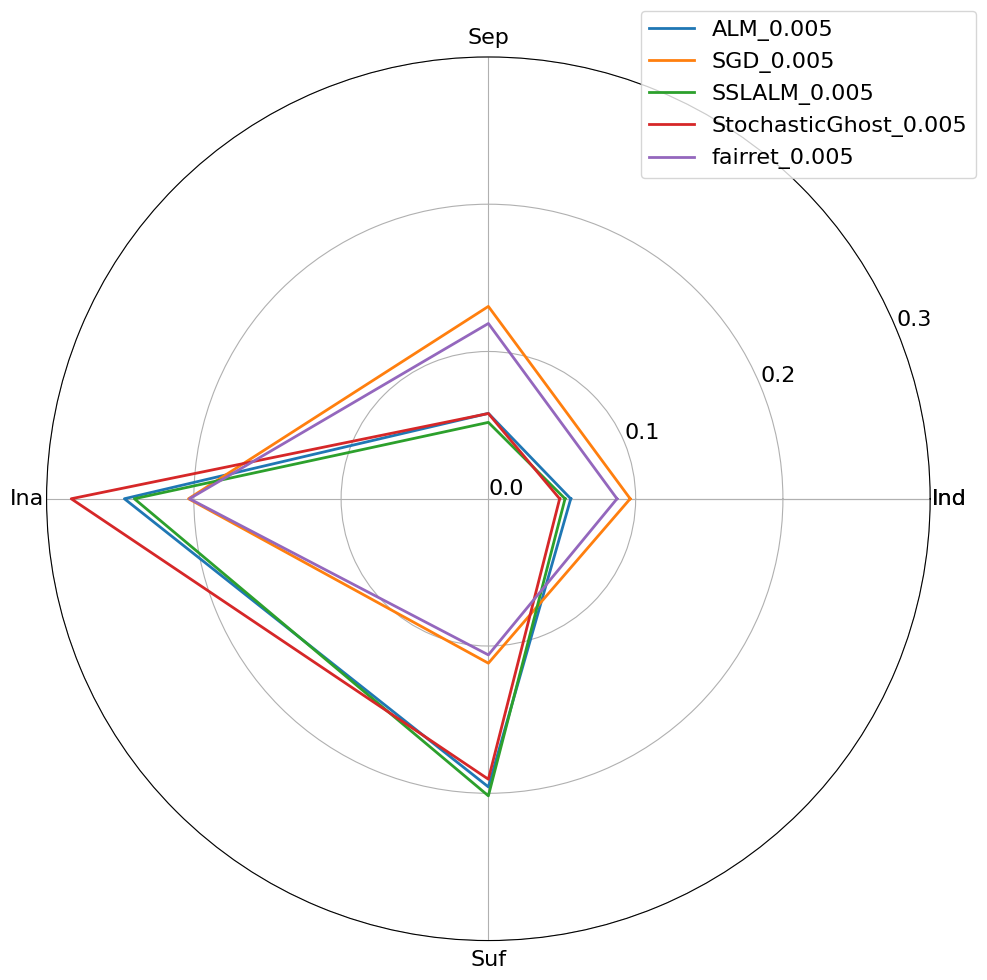

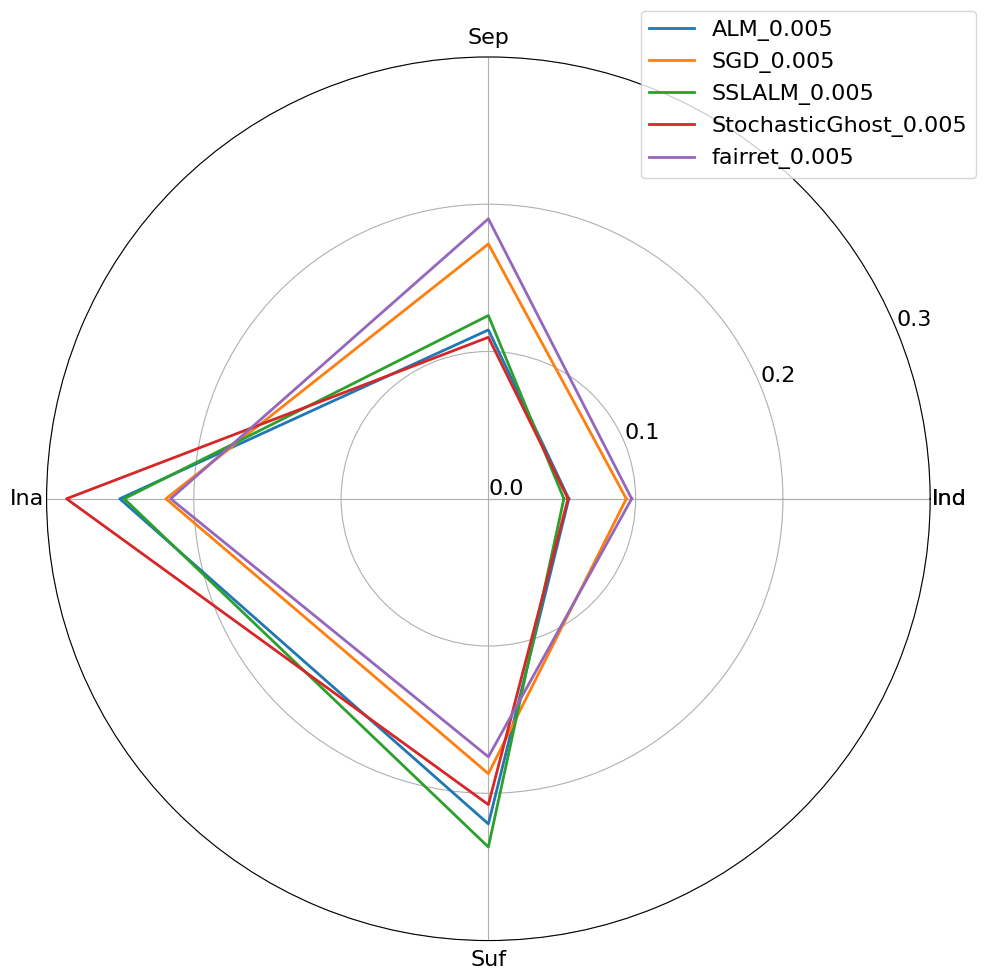

In [ ]:
from utils.plotting import spider_line


f = spider_line(train_df)
f = spider_line(test_df)

**Distribution of predictions by group:**

In [ ]:
predictions_0 = {}
predictions_1 = {}

for model_name, model in loaded_models:
    preds_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    preds_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    try:
        predictions_0[model_name].append(preds_0)
        predictions_1[model_name].append(preds_1)
    except:
        predictions_0[model_name] = [preds_0]
        predictions_1[model_name] = [preds_1]

for name in np.unique([name for name, _ in loaded_models]):
    predictions_0[name] = np.concatenate(predictions_0[name])
    predictions_1[name] = np.concatenate(predictions_1[name])

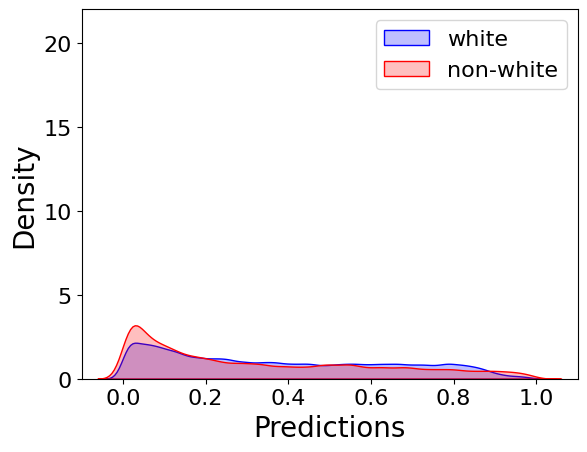

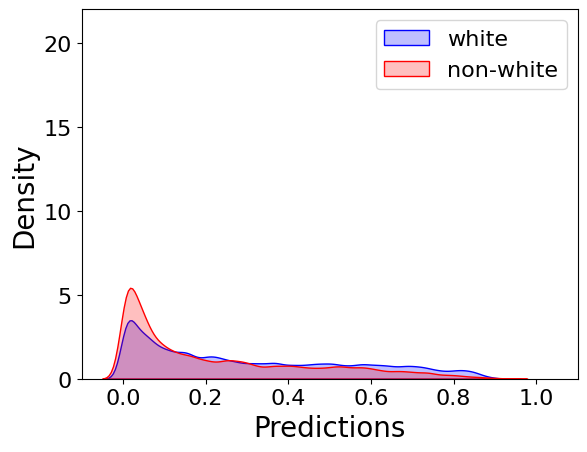

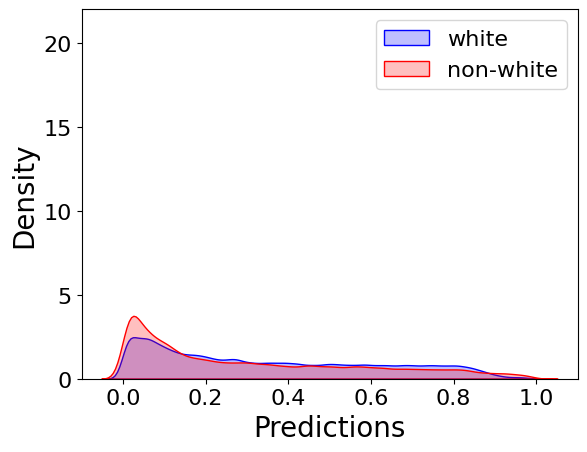

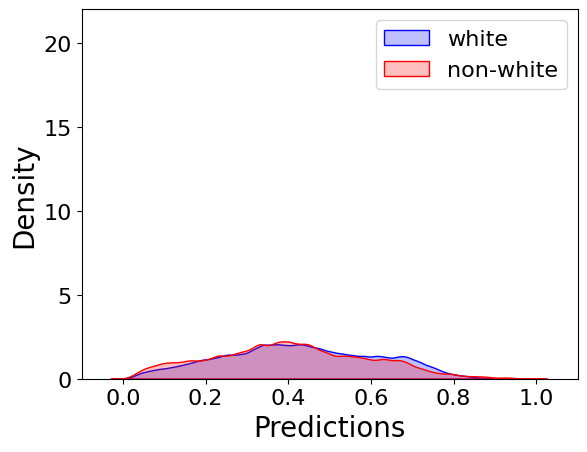

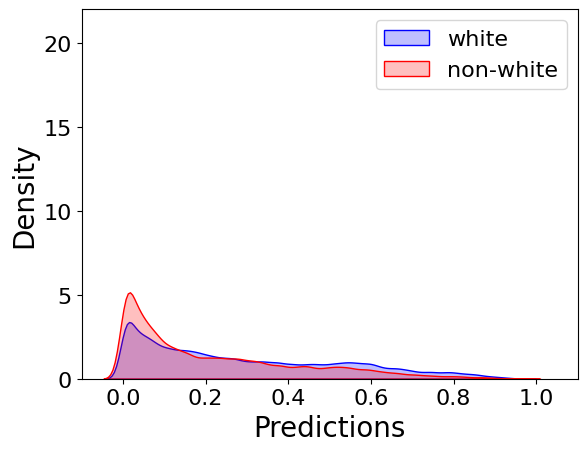

In [ ]:
import seaborn as sns

for model_name in np.unique([name for name, _ in loaded_models]):
    # predictions_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    # predictions_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()

    sns.kdeplot(
        predictions_0[model_name].squeeze(),
        label=sensitive_value_0,
        color="blue",
        fill=True,
        bw_adjust=0.4,
    )  # ,clip=[0,1],common_norm=True)
    sns.kdeplot(
        predictions_1[model_name].squeeze(),
        label=sensitive_value_1,
        color="red",
        fill=True,
        bw_adjust=0.4,
    )  # ,clip=[0,1],common_norm=True)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 22)
    plt.xlabel("Predictions", fontsize=20)
    plt.ylabel("Density", fontsize=20)
    # plt.title(model_name, fontsize=10)
    # plt.title(alg)
    # print(alg)
    alg_name = (
        "sslalm_aug"
        if model_name.startswith("sslalm_mu0")
        else model_name.split("_")[0]
    )
    plt.savefig(f"./plots/{alg_name}/{DATASET}/dist")
    plt.legend()
    plt.show()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [ ]:
select_by = "auc"

In [ ]:
best_models = {}
algs = res_df_test.Algorithm.unique()
for alg in algs:
    alg_df = res_df_test[res_df_test.Algorithm == alg]
    if select_by == "auc":
        model = loaded_models[alg_df.AUC_M.idxmax()]
    elif select_by == "wd":
        model = loaded_models[alg_df.Wd.idxmin()]
    best_models[alg] = model

#### Subgroup ROC

**TPR-FPR plot**

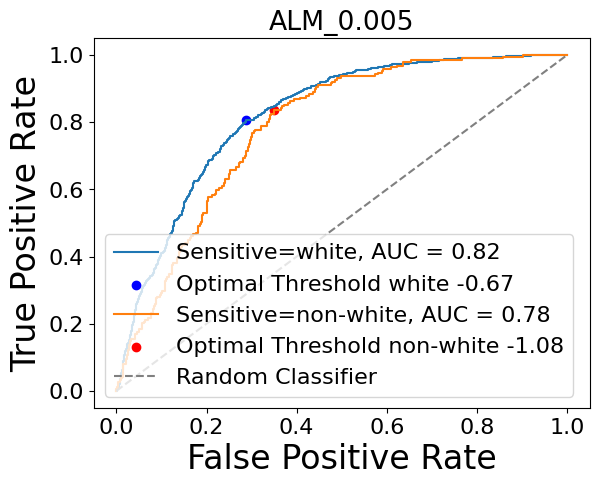

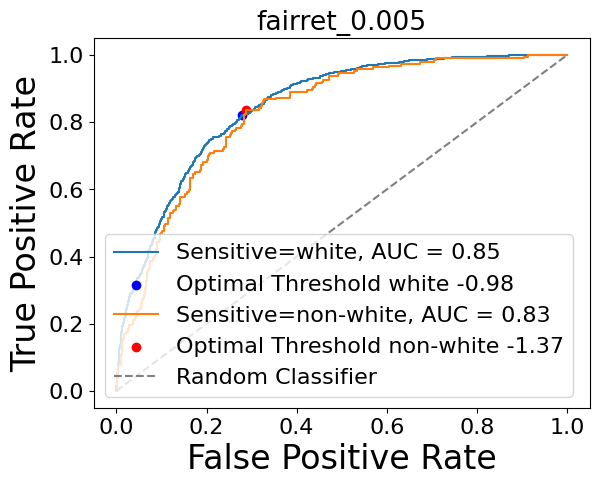

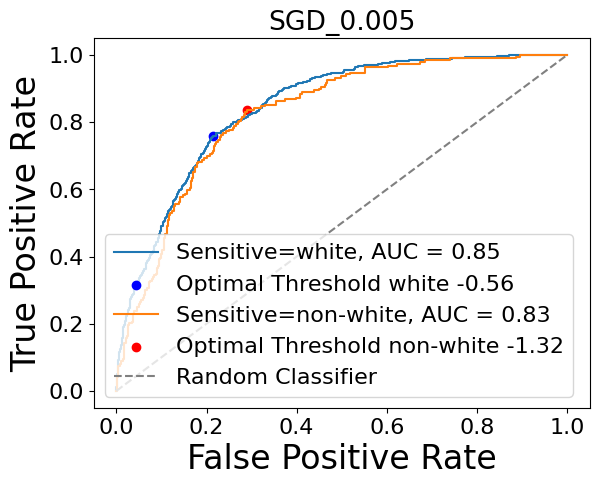

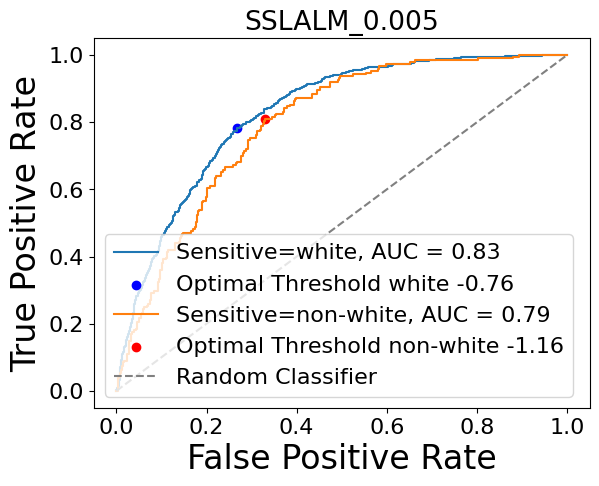

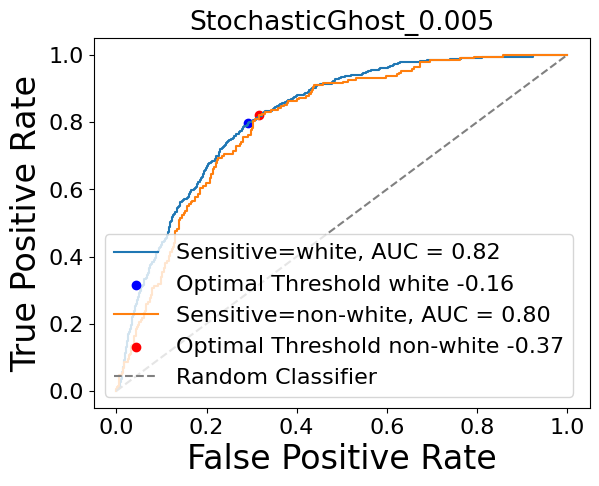

In [ ]:


# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f"Sensitive={sensitive_value}, AUC = {roc_auc:.2f}")
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        fpr[optimal_threshold_index],
        tpr[optimal_threshold_index],
        c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_pr(
            ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0
        )
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_pr(
            ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1
        )
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
        ax.set_xlabel("False Positive Rate", fontsize=24)
        ax.set_ylabel("True Positive Rate", fontsize=24)
        ax.legend()

**TNR-FNR plot**

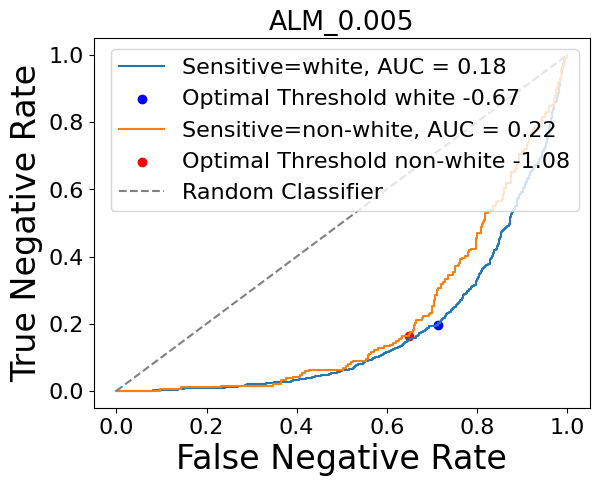

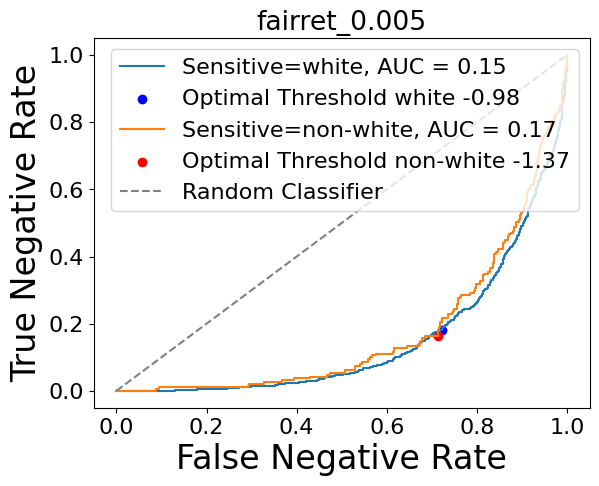

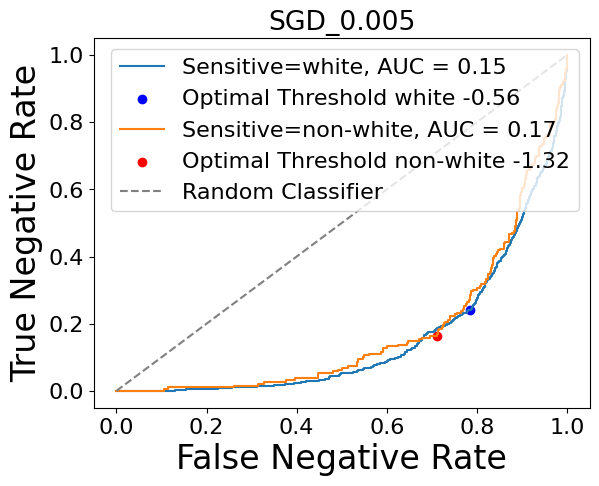

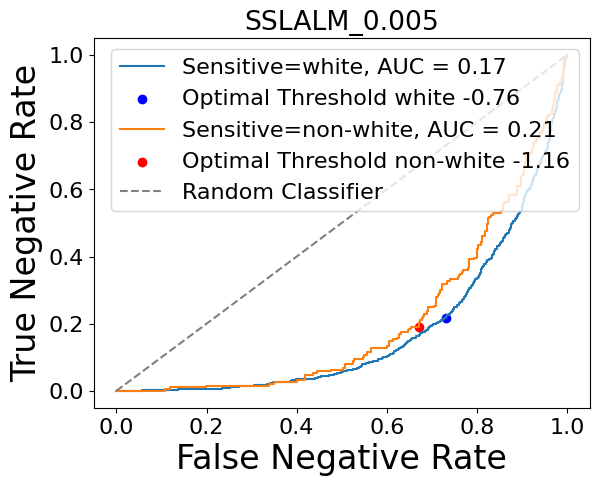

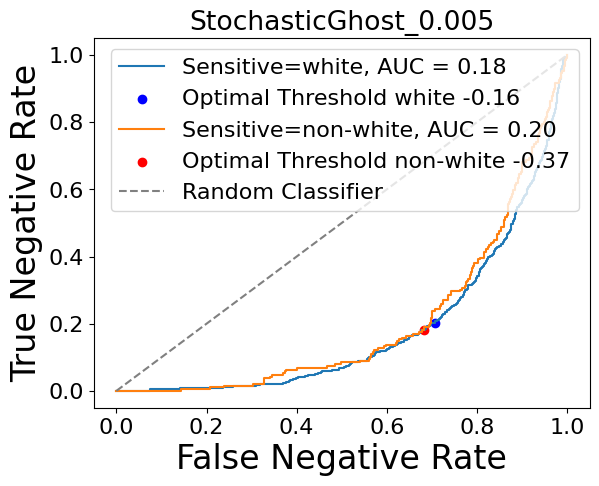

In [ ]:


# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    # predictions = predictions.detach().numpy()
    # targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = 1 - tpr
    tnr = 1 - fpr
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f"Sensitive={sensitive_value}, AUC = {roc_auc:.2f}")

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(
        tnr[optimal_threshold_index],
        fnr[optimal_threshold_index],
        c="blue" if sensitive_value == sensitive_value_0 else "red",
        label=f"Optimal Threshold {sensitive_value} {optimal_threshold:.2f}",
    )


for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax = f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_nr(
            ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0
        )
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_nr(
            ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1
        )
        ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
        ax.set_xlabel("False Negative Rate", fontsize=24)
        ax.set_ylabel("True Negative Rate", fontsize=24)
        ax.legend()